In [1]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class FLAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env
        self.q_values = np.zeros([env.observation_space.n, env.action_space.n])

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [3]:
# non-tunable hyperparameters
final_epsilon = 0.0
n_episodes = 5000
start_epsilon = 1

In [4]:
# tunable hyperparameters
learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8]
epsilon_decays = [0.0001, 0.001, 0.01, 0.05, 0.1]
discount_factors = [0.9, 0.95, 0.99, 0.999]

In [5]:
env = gym.make('FrozenLake-v1')
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

In [6]:
def pickle_dump(file, filename):
    with open(filename, 'wb') as f:
        pickle.dump(file, f)

def pickle_load(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def optimize_hyperparameters():
    best_avg_steps = 0
    best_hyperparameters = (0, 0, 0, 0)

    for learning_rate in learning_rates:
        for epsilon_decay in epsilon_decays:
            for discount_factor in discount_factors:
                avg_steps = train_agent(learning_rate, start_epsilon, epsilon_decay, discount_factor)
                if avg_steps > best_avg_steps:
                    best_avg_steps = avg_steps
                    best_hyperparameters = (learning_rate, start_epsilon, epsilon_decay, discount_factor)


    
    return best_avg_steps, best_hyperparameters

def train_agent(learning_rate: float, 
                start_epsilon: float, 
                epsilon_decay: float, 
                discount_factor: float,
                log=False,
                steps_limit: int=100) -> float:
                
    agent = FLAgent(
        env=env,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount_factor,
    )
    
    steps_lst = []
    rewards_lst = []
    avg_steps_lst = []


    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False
        steps = 0

        # play one episode
        while not done and steps < steps_limit:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            # update the agent
            agent.update(obs, action, reward, terminated, next_obs)
            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs
            steps += 1

        rewards_lst.append(reward)
        steps_lst.append(100 if not reward else steps)
        agent.decay_epsilon()

        if log:
            if episode in (500-1, 2000-1, 5000-1):
                pickle_dump(agent.q_values, f'q_values_{episode + 1}.pkl')
            if episode % 100 == 0:
                avg_steps_lst.append(np.mean(steps_lst[-100:]))

    if log:
        pickle_dump(rewards_lst, 'rewards.pkl')
        pickle_dump(avg_steps_lst, 'avg_steps.pkl')
    
    return np.mean(steps_lst)


**Run Grid Search for Hyperparameters**

In [ ]:
best_avg_steps, best_hyperparameters = optimize_hyperparameters()

pickle.dump(best_hyperparameters, open("best_hyperparameters.pkl", "wb"))
print(f"Best average steps: {best_avg_steps}")
print(f"Best hyperparameters: {best_hyperparameters}")

In [8]:
# non-tunable hyperparameters
final_epsilon = 0.0
n_episodes = 5000
start_epsilon = 1


# hyperparameters after GS
learning_rate = 0.5
epsilon_decay = 0.001
discount_factor = 0.999


# training agent with logging
train_agent(learning_rate, 
            start_epsilon, 
            epsilon_decay, 
            discount_factor, 
            log=True, 
            steps_limit=float('inf'))

100%|██████████| 5000/5000 [00:02<00:00, 2327.66it/s]


74.507

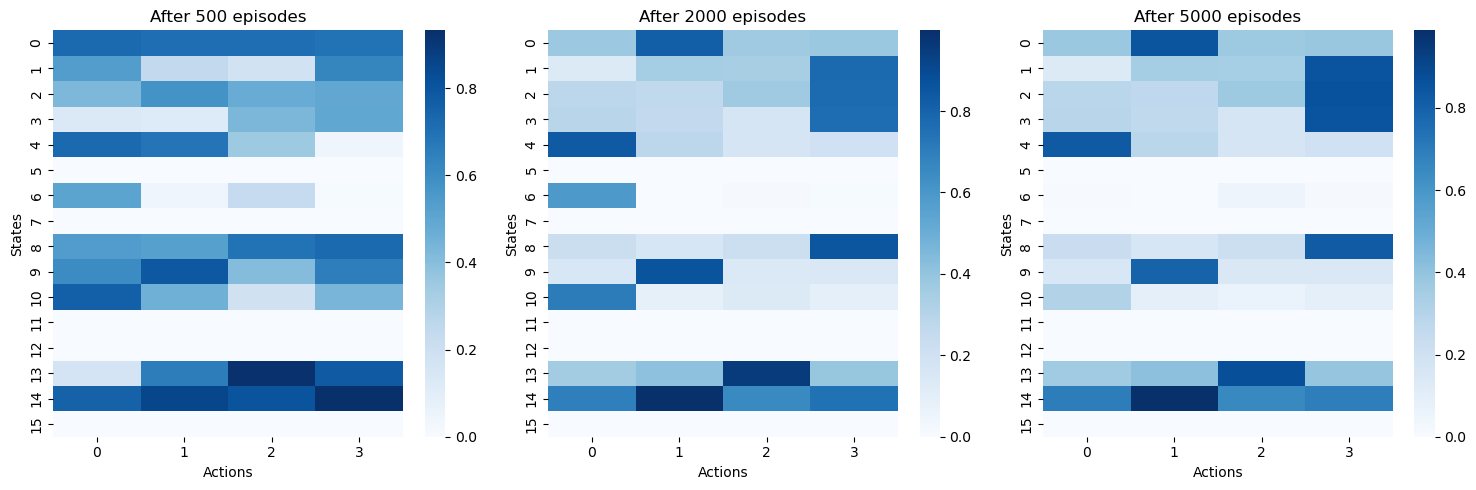

In [9]:
q_values_500 = pickle_load('q_values_500.pkl')
q_values_2000 = pickle_load('q_values_2000.pkl')
q_values_5000 = pickle_load('q_values_5000.pkl')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
titles = ['After 500 episodes', 'After 2000 episodes', 'After 5000 episodes']
q_values_matrices = [q_values_500, q_values_2000, q_values_5000]

# Plot each Q-value matrix as a heatmap in a subplot
for i, ax in enumerate(axs):
    sns.heatmap(q_values_matrices[i], fmt='.2f', cmap='Blues', ax=ax)
    ax.set_title(titles[i])
    ax.set_xlabel('Actions')
    ax.set_ylabel('States')

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

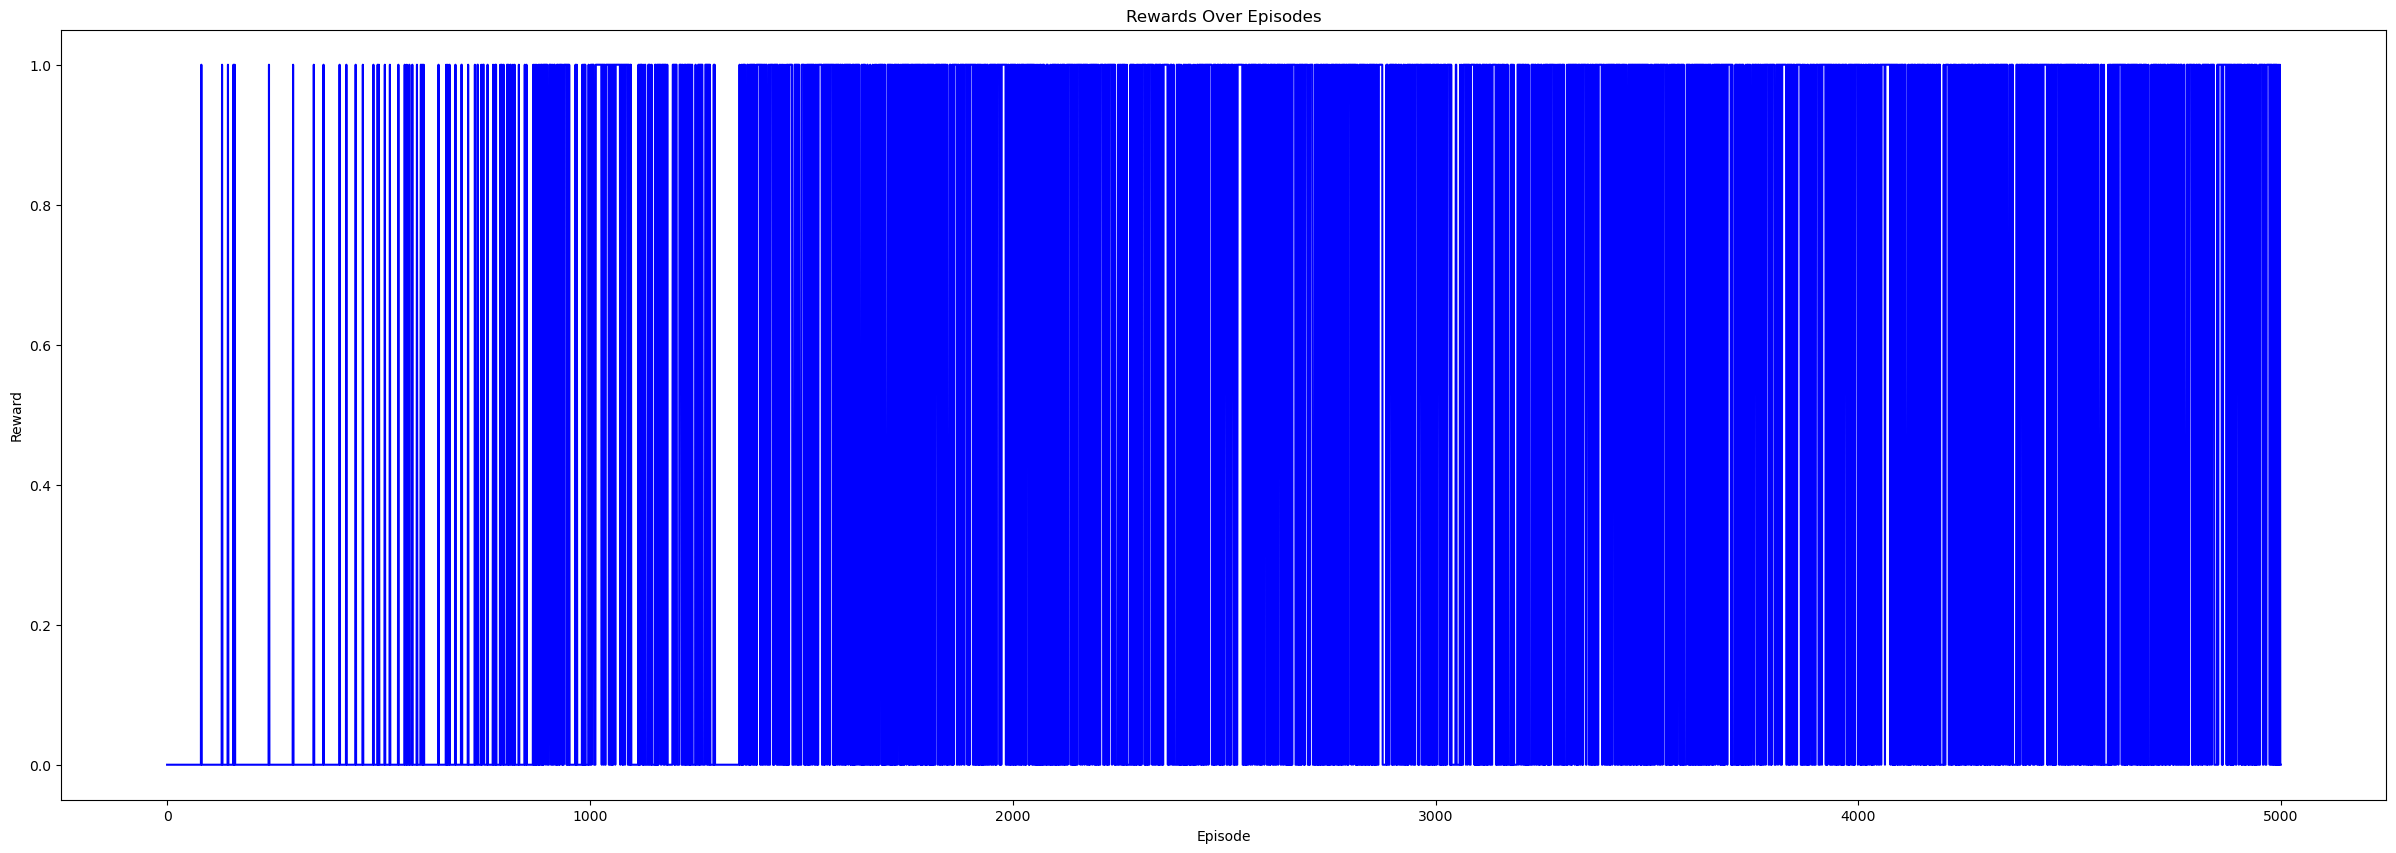

In [14]:
rewards = pickle_load('rewards.pkl')

# Plotting the rewards over episodes
plt.figure(figsize=(30, 10))
plt.plot(rewards, label='Reward per Episode', color='blue')
plt.title('Rewards Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

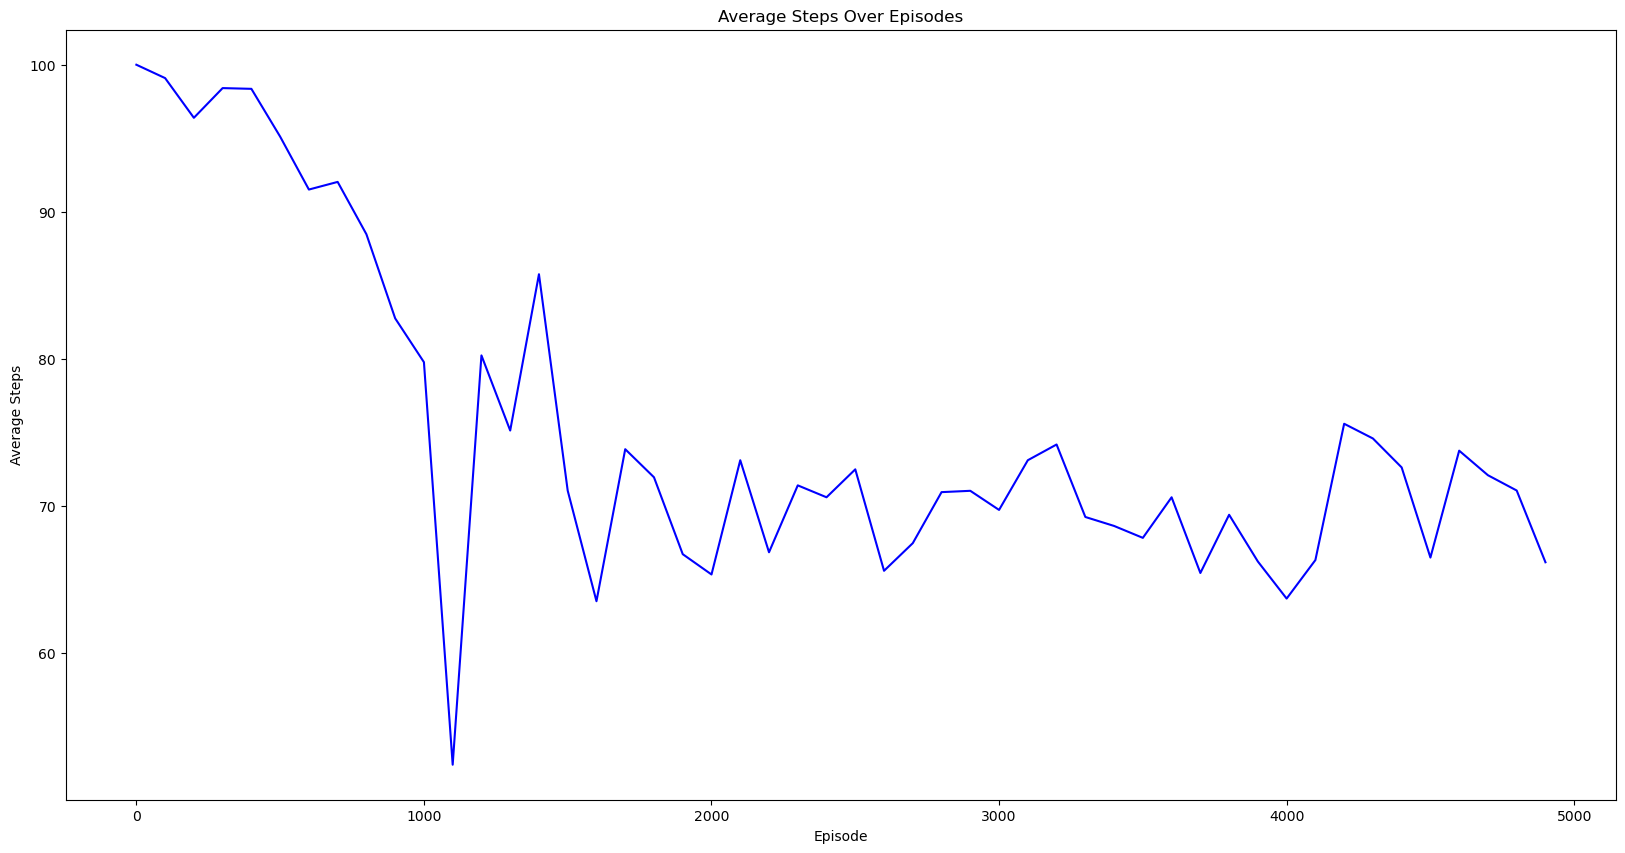

In [16]:
avg_steps = pickle_load('avg_steps.pkl')
episodes_axis = 100 * np.arange(len(avg_steps))

# Plotting the average steps over episodes
plt.figure(figsize=(20, 10))
plt.plot(episodes_axis, avg_steps, label='Average Steps per Episode', color='blue')
plt.title('Average Steps Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Steps')
plt.show()